# Robotics and RL Project: Deep Reinforcement Learning on Robot Navigation

`Student Name : Ahmet Guzel`
`Student ID : 201566595`

## Content
-------------------------------------------------

1. Summary and Introduction                                                  
1. Environment design and justification                                      
1. Robot model correctly use frames and sensors                              

1. Deep learning Model architecture and parameters tuning and justification  

1. Navigation Model 1   
    1. RL Algorithm implementation and parameters tuning and justification   
    1. Learning plots, convergence rate and success rate of the model        

1. Navigation Model 2
    1. RL Algorithm implementation and parameters tuning and justification   
    1. Learning plots, convergence rate and success rate of the model        

1. Manipulation Model Implementation and justification                       
1. Analysis of the results                                                   
1. Conclusion and Reflection on what went wrong and what worked well         




### 1. Summary and Introduction

This projects explores the challenge of autonomous mobile robot navigation in complex environments. The objective of autonomous mobile robot navigation is to reach goal position and return back to original position, without colliding with obstacles. Between two objectives, there is another task which is robot should manipulate the object on the goal position, before returning the starting position of task one. 

Instead of path planning and SLAM algorithms, deep reinforcement learning is applied in this project. There are two different reinforcement learning methods are applied during start position to goal and goal to start position. Both methods are designed with neural network architecture (deep reinforcement learning). 

1st Method : Deep Reinforcement Learning 1 (Policy Gradient) for navigation 1

2nd Method : Deep Reinforcement Learning 2 (DQN) for navigation 2 

In this project Gazebo is used as simulator, since it best supports the requirements for training the navigation robot agent. It provides physics engine and sensors simulation at faster than real world physical robot. OpenAI Robot Operating System (OpenAI ROS) is also used in this project. OpenAI ROS interfaces directly with Gazebo, without necessitating any changes to software in order to run in simulation as opposed to the physical world, and it provides wide range reinforcement Learning libraries that allow to train turtlebot on tasks. Since creating this simulation ecosystem for the project is time consuming, a virtual machine is provided by the instructor is used instead of creating from sctrach.Instead of VM ready world,a new world is created for navigation task. 

Hyper parameter tunning and reward function design are studied,and results are compared in terms of total reward after each step.  




### 2. Environment Design And Justification 

#### 2.1 Environment Design
The project requires a navigation environment which should be created in Gazebo simulator. Total framework of the simulation area is 9m x 5m flat, with 2.5m x 5m room with 1.5m x 2.0m bed. A worktop and TV are placed to the flat. Robot start position and goal position is place in Figure 2 below. 


For creating the walls, build editor option is used inside the Gazebo simulator. After walls are created, worktop, bed, and TV are placed inside the walls by using approximations to match best plan with the asked environment in Figure 1. 

Instead of using VM provided kitchen world ready model from Gazebo library, in this project the environment is created to speed up the graphics, since kitchen world simulation in VM runs around 2fps. Moreover, shadows are removed from the world and OpenGL settings are changed (version downgrade) to increase fps. With the new environment and settings, simulation run with ~50fps which increase the speed of learning trials dramatically. 


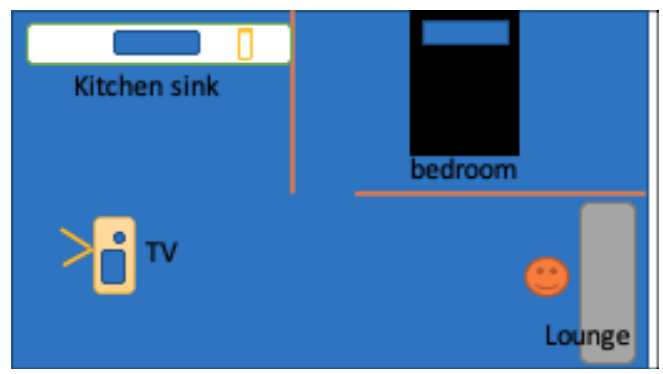

In [ ]:
from IPython.display import Image
Image('/content/Env_Brief.png', width=350, height=200)

Figure 1

Robot Starting Position : `X [-6.0], Y[-5.0]`

Coke Can (Goal) Position : `X[4.0], Y[-1.0]`


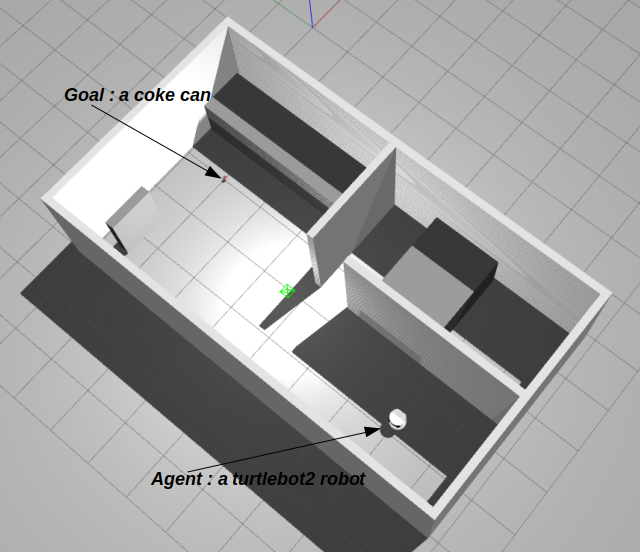

In [ ]:
Image('/content/env3d_coke_arrows.png', width=350, height=300)

Figure 2

#### 2.2 Accessing The Envrionment Variables

OpenAI Gym toolkit developed by OpenAI is used to access the turtlebot2 environment, we can use env = gym.make("turtlebot2_wall.py"), which we gained access to when we imported the gym package. "env" provides state, observations, rewards, done which are used for learning algorithms as a observable and calculated values. 

#### 2.2.1 State Representation

At each time-step the turtlebot uses the current state to decide what action to take to maximize future rewards. The state should feed information about the environment at current time step where turtlebot can make the best decision. The state camera, odometry data, laser scan is used for state representation. In addition to this heading to goal and distance to goal are added for reward function design. 

##### 2.2.2 Distance To Goal 

Distance to goal calculation is added to turtlebot environment model to improve training. This is normally not possible without SLAM in real world unknown envrionment for the robot, but in this project calculation is added to reward function design for improving training purposes. 


    if distance_difference < 0.0:
      reward += self.forwards_reward
    else:
      reward -= self.forwards_reward

##### 2.2.3 Heading to Goal
In addition to using the distance to the goal, which is difficult to sense in practice, measuring the relative heading does not have any dependence on SLAM. In this project, aim for using this information is exploring the improvement on reward fuction which improves the training time and convergence.
In turtlebot2_wall.py file, code below is added to implement. Basically it uses atan2 formulation with distance between robot's location and goal point. Odometry data is used to get orientation where it will be passed to euler_from_quaternion method (imported from tf.transformations library) calculating roll pitch and yaw (theta). 
Then cosinus of the angle calculated for reward function. Since robot is placed initially with desired yaw, it is subtracted from the point_angle_to_goal value. Figure 3 shows theta angle to clarify implementation below.

        odometry = self.get_odom()
        rot_q = odometry.pose.pose.orientation          
        (roll, pitch, theta) = euler_from_quaternion([rot_q.x, rot_q.y, rot_q.z, rot_q.w])
        inc_x = goal_x - current_position.x
        inc_y = goal_y - current_position.y

        heading_to_goal = cos(-theta+point_angle_to_goal)
        point_angle_to_goal = atan2 (inc_y, inc_x)

        if  distance_difference < 0.0 and heading_to_goal > 0.7:                
           reward = 0.5
           rospy.logerr("HEADING TO GOAL REWARD Positive : " + str(reward))
	    else:
            reward = -1 * 0.5
		    rospy.logerr("HEADING TO GOAL REWARD Negative : " + str(reward))


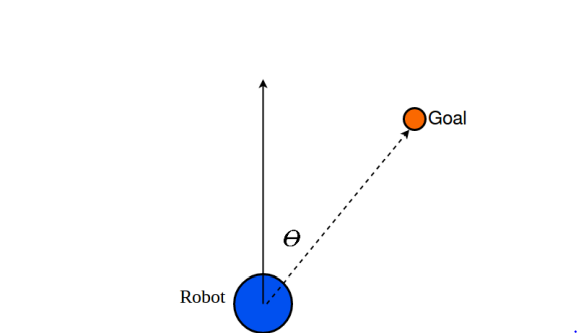

In [ ]:
Image('/content/headingtoGoal.PNG', width=350, height=200)

Figure 3

#### 2.2.2 Action Space 
The turtlebot agent determines control actions. For the agent it is possible to command linear and angular velocity. These values are set under configuration file where also target locations is set. In this project, robot has three action spaces:

Forward, Turn Right, Turn Left

These actions are completed in each time step with the selected speed values under the configuration file. In RL implementation actions are created as three element array as [0, 1, 2].

Speed Setting : 

To increase the training time, speed is increased from baseline values provided by VM as below.

**linear_forward_speed**: 0.65 m/s (closer to Turtlebot Kobuki speed limit)

**linear_turn_speed**: 0.05 m/s

**angular_speed**: 0.3 m/s

#### 2.2.3 Reward Function 

The objective of the agent is reflected in the design of the reward function. For the  problem of autonomous mobile robot navigation, the reward function should reward the agent for moving the robot toward and reaching the goal location, and penalize it for moving away from the goal and colliding with obstacles. To achieve this, the following reward function was designed


**forwards_reward** : 1 point

**turn_reward** : 0.5 point

**end_episode_points** : 100 point


**State 1** - Distance Difference < 0 

Agent gets rewards when distance between agent and goal is decreasing in successive time steps. 

            if distance_difference < 0.0:
              reward += self.forwards_reward 
            else:
              reward -= self.forwards_reward 


**State 2** - Heading to Goal & Distance Difference < 0

When the angle between robots direction and the goal location is more than 50 degree and distance difference is negative, robots get reward as implemented below. This idea is adaptod from a thesis by Ryan Weidaman (2019,  Robot Navigation in Cluttered Environments with Deep Reinforcement Learning)

            if  distance_difference < 0.0 and heading_to_goal > 0.65:                  
                reward = 0.5
	        else:
	            reward = -1 * 0.5

**State 3** - Reaching The Desired Position or Crashing The Wall/Objects
 
Once robot reaches the target with +/- 0.5 meter threshold, it will be rewarded by 100 points. When agent crashes the wall/object , 100 points substracted from episodes cumulative reward. 

            if self.is_in_desired_position(current_position):
                reward = self.end_episode_points
            else:
                reward = -1*self.end_episode_points

### 3. Robot Model Correctly Use Frames And Sensors



Three different sensing method is used in this project to make observations. 

1st - Odometry via wheel encoders. 

2nd - Laser scan with settings below. These settings are modifiable inside the configuration file of turtlebot2.

Laser scanning is determining the how far the robot is with the wall or object. 

  *`new_ranges: 5`* 
  
  *`min_range: .25 `*

  *`max_laser_value: 1`* 
  
  *`min_laser_value: 0`*

3rd - RGB camera 

#### **3.1 Localisation**

It features a two-wheeled differential drive train. The differential drive train allows the robot to turn about its centre point, which is very useful for changing directions without needing to move forward or backward where heading to angle works with this ability and improve training with given rewarding function. 
Deep neural network represents end-to-end model which is simplified by a pipeline which constructs from sensor input to robot controls. In this way, manual tuning of collection of algorithms is eliminated. 

In Markov decision process, robot's probabilistic localisation problem is eased by using both odometry data and laser scan data. In this project, agent needs to be localised precisely since aim of the agent is reaching one point to another. Therefore, laser scan data and odometry data is combined to improve accuracy of robot's pose and location. In turtlebot2_env.py file, observations are implemented as below. Then agent's position data is accessible from the observations array which has 6 elements. 

    observations = discretized_laser_scan + odometry_array
    current_position.x = observations[-2]
    current_position.y = observations[-1]

In heading to goal implementation, robot uses orientation data which is accessible from the odometry data. Therefore, implementation below is completed to achieve this

    odometry = self.get_odom()
    rot_q = odometry.pose.pose.orientation 

In each episode, agent should use a logic to terminate the episode. This is mainly implemented in _is_done(self, observations) function under the turtlebot2_env.py. 

In baseline VM implementation, agent's space is limited by minimum and max x, y values as solving the agent's movement outside of the designed navigation environment. In this project limits are changed to wider boundaries as designed navigation environment is fully enclosed with walls.  

#### 3.1.1 Termination scenarios using locasition data, 

1st - Crashing the object or wall 
`_episode_done` class member is storing the binary information about wheter agent has crashed or has reached the target.  


2nd - Reaching the goal with a threshold value +/- 0.5m. 

Implementation below is added to baseline VM.

    distance_from_des_point = self.get_distance_from_desired_point(current_position)
    if distance_from_des_point < 0.5:
       rospy.logerr("Turtlebot has reached the target with distance ==> " +str(distance_from_des_point))
       self._episode_done = True         




#### **3.2  RGB Camera Image Processing**

In RL algorithms in this project, convolutional neural network is used to train the network via image data taken by turtlebot RGB camere before processed by the ROS/cv2 bridge. ` CvBridge ` object is intantiated to create OpenCV images. Raw image data from ROS is passed from the `imgmsg_to_cv2()` with encoding selection where in our case `brg8` selected as it is default when converting images from ROS to OpenCV. 

`img1` variable is created to pass convolutional neural network in RL training.  

    bridge_object = CvBridge()
    cv_image = bridge_object.imgmsg_to_cv2(env.get_camera_rgb_image_raw() , desired_encoding="bgr8")
	img1 = cv2.resize(cv_image[1::-1], (84,84))

### 4. Deep Learning Model Architecture And Parameters Tuning And Justification

In this project three different type deep learning architecture is used. Tensorflow keras is used to create architectures. 
Initial shared VM environment comes with CNN architecture, and in this project one of the algorithm uses that architecture with some addition to network which explained in below. 

Neural network architectures that used in the project :

##### **4.1- Artificial Neural Network Architecture (Feed-Forward Neural Network**) 

The network has inputs where `observations` is passed to network model and actions (number of three) output of the model. So, three output is designed for output layer. 

In between layers, ReLU activation function is used. 

#####***NN Architecture 1 [ANN, FCN, FNN] :***

    def create_turtlebot2_model():
      model = tf.keras.models.Sequential([
          # Input Dense layer
          tf.keras.layers.Dense(units=64, activation='relu'),       
          # Hidden Dense Layer
          tf.keras.layers.Dense(units=32, activation='relu'),       
          # Output dense layer
          tf.keras.layers.Dense(units=3, activation=None)       
      ])
      return model 

For hyper-parameter tuning, 

Instead of using single layer network, double layer is selected. This is after both double and single layer network is compared in terms of convergence rate performance. Double layer network is definetely increases the training time, but with applied RL method with this network convergences before 100 episodes as it will be shown in section 5.

In terms of optimizer and learning rate, 0.001 is selected and Adam is used as optimizer during the training.

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate)

Training function design :

    Forward pass `observations`
      calculate loss by using loss function
      get gradients 
      optimize 
  
Implementation is below, and loss function is explained in "RL method one" section in detail. In code files, implementation has more lines but main idea is here to show how training function is designed with main points. 

    def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
        with tf.GradientTape() as tape:
        #Forward pass          
        prediction = model(observations)
        #calculate the loss 
        loss = loss_function(prediction, actions, discounted_rewards)
        #get gradients
        grads = tape.gradient(loss, model.trainable_variables) 
        grads, _ = tf.clip_by_global_norm(grads, 2) 
        #optimisation
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

##### **4.2- Convolutional Neural Network (CNN) Architecture**

The idea is not far away from the first feed-forward neural network as an architecture however this time `images` are passed to network model instead  `observations`. In this way agent can learn based on images processed in each time step. It uses OpenCV images from to `CvBridge()` and train the algorithm. 

To pass images into network, convolutional neural network should be created.
#####***NN Architecture 2 [CNN] :***


    def CNN_model():
      model = tf.keras.models.Sequential([
          # Convolutional layers
          Conv2D(filters=32, kernel_size=5, strides=2, input_shape=(84,84,3,)),
          Conv2D(filters=48, kernel_size=5, strides=2),
          Conv2D(filters=64, kernel_size=3, strides=2),
          Flatten(),
          # Fully connected layer and output
          Dense(units=512, activation=act),
          Dense(units=3, activation=None)
      ])
      return model

This architecture is originally inspired from "MIT Deep Learning (http://introtodeeplearning.com/)" course, and batch normalization can be added to original architecture to reduce overfitting but since single image is used for training instead of batches, it will not be beneficial. 

The other parts of the architecture is similar to first architecture but this time learning rate is reduced to 0.0005 to improve training. 

For the loss function definition and memory concept, RL algorithm implementation is used for explanation. 

Why Two different architecture is designed is to see effect on RL training like performance and training time, and convergence. 

### 5. Navigation Model 1 [From Starting Point to Goal Point]

In this part of the project, everything combined to create a RL algorithm and try to navigate agent in the designed environment. 

In any RL algorithm which can be studied in the context of this project should have the data from the environment. Therefore the code line below carries a crucial information to be successful in any RL algorithm implementation. 

`observation, reward, done, info = env.step(action)` 

It means that every action which is defined by the RL algorithm's output, will be passed to the environment step function which return three important parameters as observation, reward, and done for the RL algorithm which is shown in this project. 

In section 4, two different NN architecture are defined and feed-forward neural network needs `observation` for forward pass and `rewards` for loss calculation. Moreover OpenCV `image` data also is needed for forward pass to second architecture which uses the CNN. 

##### **5.1. Reinforcement Learning Method for Navigation 1**

For the first RL algorithm which is used for training the agent to perform start point to goal point (coke can), policy gradient method used. 

The policy gradient method optimizing the policy ${\pi}(a|s)$ directly.

For the implementation, getting large rewards relies on maximising the likelihood of actions. In another way, the negative likelihood of these same actions is desired to be minimised. Achieving this is possible with scaling the probabilities by their associated rewards which turn in increasing the likelihood of actions resulting high rewards. 


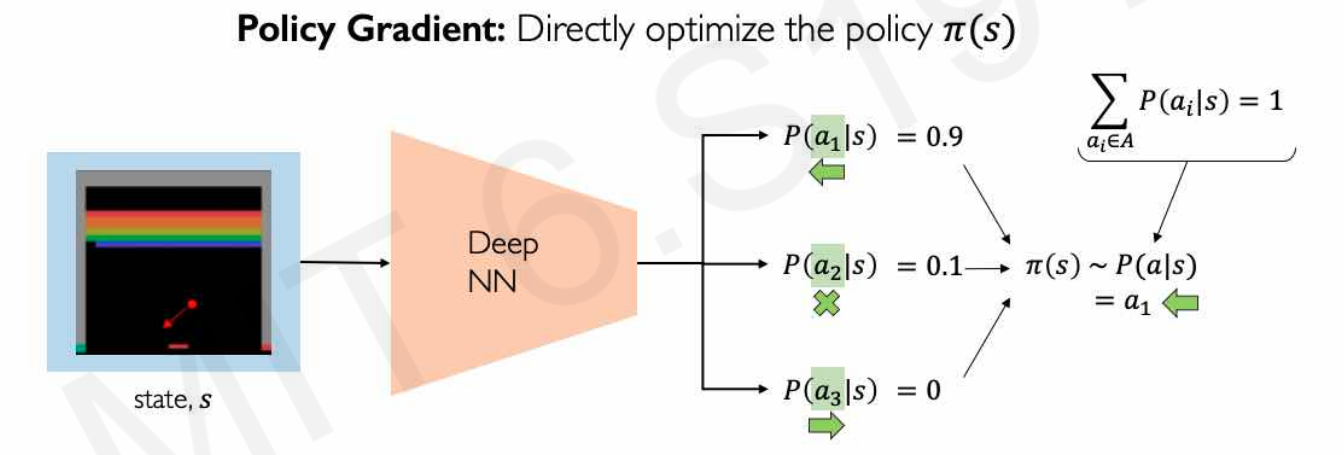

In [ ]:
Image('/content/policy_gradient.png', width=600, height=250)

*Reference : MIT Deep Learning (http://introtodeeplearning.com/)*

Figure 4 [ref: MIT Deep Learning Course] 

In previous section, some parts of the architecture is introduced. In this section loss and memory implementation with training methodology is explained. 

##### **5.1.1 Reward Function**
Uncertainty about when the game or task will end, getting rewards now rather than later in the future is a good choice.

To compute the cumulative reward as a return, at a given timestep in a learning episode, we sum the rewards expected at that time step , within a learning episode, and projecting into the future.

Return is defined as below 

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$ 

where $0 < \gamma < 1$ is the discount factor and $r_{t}$ is the reward at time step $t$, and the index $k$ increments projection into the future within a single learning episode.

##### **5.1.2 Loss Function**

Calculating the negative log-likelihood of actions in a discrete way is implemented evaluating its softmax-cross-entropy.Therefore, using a stochastic gradient descent methods to achieve minimising negative log-likelihood is a chosen method for the first RL similar to supervising learning method. Figure 4 below shows the diagram of the RL architecture.

`sparse_softmax_cross_entropy_with_logits` method is used from tensorflow.nn library, and implemented as below

def compute_loss(logits, actions, rewards): 
logits=logits, labels=actions) 
loss = tf.reduce_mean( neg_logprob * rewards )
return loss

For hyperparameter tunning, learning rate is chosen as 0.001 and ${\gamma}$ value is selected as 0.95. 

In this project it was not possible to change them frequently and analyse the differences due to time, performance and modelling challenges.

##### **5.1.3 Memory Buffer**

Define our agent's memory: this will enable the agent to remember its past actions, observations, and rewards.

##### **5.1.3 Training Performance and Results**

The main objective is converging to rewards and get agent from starting point to goal point. 

Two neural network architecture which are defined above is used to see differences in the training. 

For the total rewards in each episode, rolling average for 20 step is used for removing the noise from the results. 

Both image based method with CNN and observations based method with ANN have been tested. Cumulative results for each in a chart below.


##### **5.1.4 Training Function Design [Algorithm]**

Implementation of algorithm is different than policy gradient method as Q values are used in this methodolgy. 

    for episodes in number of episodes:
      observation -> env.reset()  
      clear memory
      while true:
        get action by using exploration rate and max(Q Values)
        new observation,reward, done, info -> env.step(action)
        add observation, observation, reward to memory buffer
        if done:
          train the agent
          clear the memory
          exit from while loop
      observation -> new Observation


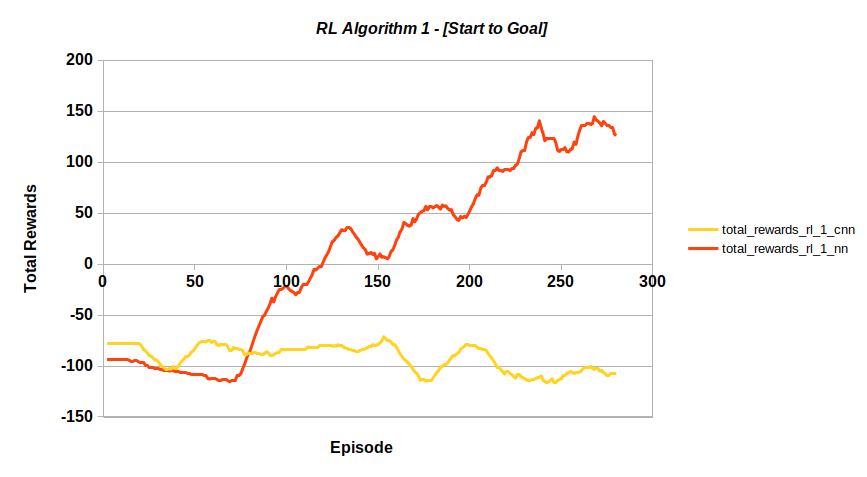

In [ ]:
Image('/content/Results_RL_1.png', width=650, height=375)

Chart 1 : Episode vs Total Rewards for RL Algorithm 1 


Firstly, training time is limited with 280 since ANN method is converged at this value and even CNN has been kept running to >1000 episodes, it did not converge to higher rewards. So, keeping the chart is clear, after 280 is removed. 

From the results above, it can be seen that ANN with observation passing (first method in chapter 4) outperforms the CNN. This can be addressed to different reasons. First of all, it is a single batch training, and single image for each time step may not be good choice. Also, we use a RGB camera, and it may be better to use depth sensing camera for the comparison, since distance information is not available with the RGB camera even we design a reward function with distance difference value for each time step. 

Success rate is ~20% with 0.5m goal reaching threshold. Success rate may be a lower with exact location of goal is selected as rewarding point and not to finish step once robot reach the goal within threshold. 

Convergence happens after 220 episodes so in each 50 episodes, 50 reward point in average is observed. Therefore 1 reward / 1 episode rate is achieved.


### 5. Navigation Model 2 [From Goal Point to Starting Point]

In this part, the turtlebot environment should swap the goal and start position.
Since training of agent is allowed for separately as one for goal to start and other one goal to start, in this part another reinforcement algorithm is used to train the agent separately. 

##### **5.1. Reinforcement Learning Method for Navigation 1**

The selected algorithm for implementation is DQN. And this time ANN is used for training as it is concluded that from the first part, CNN is not good as ANN for some reasons. Having said that, RL 1 algorithm is used again in this navigation model to compare the results. 

In DQN implementation, observations are fed to ANN and expected return is maximised with minimising the mean square loss. Target and prediction are used for calculating this loss and the figure below is summarise the approach. 

Basically, learning the policy via selecting maximum Q value from the action which is based on output of neural network. 

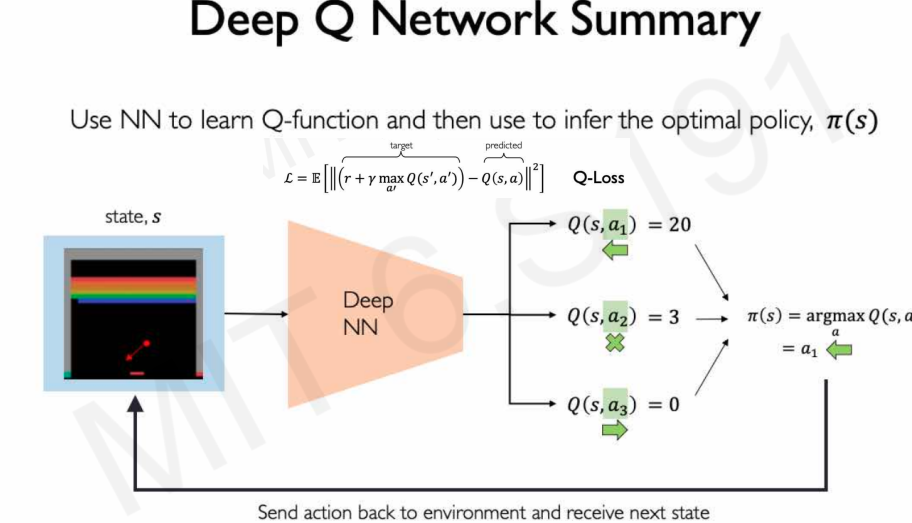

In [ ]:
Image('/content/dqn_loss.png', width=650, height=375)

*Reference : MIT Deep Learning (http://introtodeeplearning.com/)*

Implementation of core components like memory, neural network architecture is similar and share codes between them, therefore same parts of implementation are not redefined here.The difference is the training section. 

##### **5.1.3 Training Function Design [Algorithm]**

Implementation of algorithm is different than policy gradient method as Q values are used in this methodolgy. 

    for episodes in number of episodes:
      observation -> env.reset()  
      while true:
        get Q Values by passing observations to network
        get action by using exploration rate and max(Q Values)
        new observation,reward, done, info -> env.step(action)
        add observation, new observation, reward, done to memory buffer
        if done:
          train the agent
          clear the memory
          exit from while loop
      observation -> newObservation






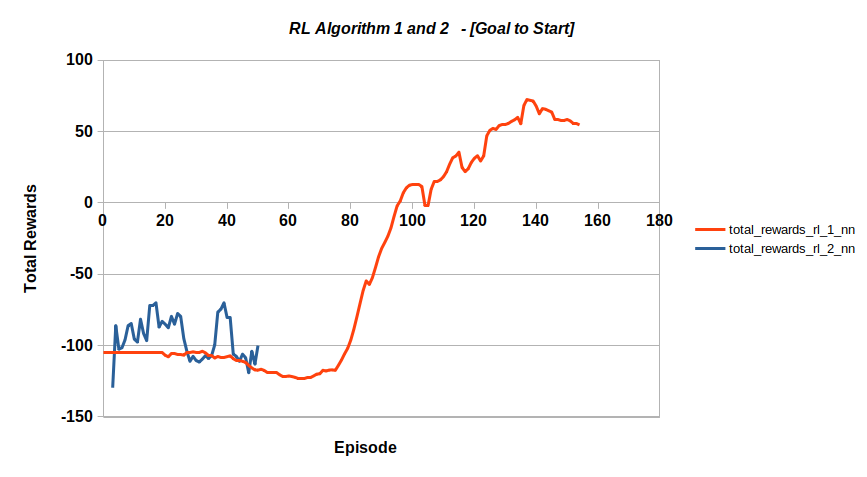

In [ ]:
Image('/content/Results_RL_12.png', width=650, height=375)

Chart 2 : Episode vs Total Rewards for RL Algorithm 2


The DQN algorithm has a problem with simulation where VM is not performing the simulation after around ~50 episodes due to memory issues. In this project this is kept as an open problem as solution was not found. 

Once reinforcement 1 algorithm runs with the same goal, it converged even faster than first navigation model. 

RL 2 algorithm's results are not averaged while RL 1 algorithm's averaged with rolling average with 20 episode points. 

Since there is no convergence and success for the second algorithm we can not mention the success rate and convergence rate. For the RL1 convergence rate is higher compared to navigation model 1. 



### 7. Robotic Arm Manipulation
This part is not studied in this project as time and source issues that I have been struggled.
### 8. Analysis Of The Results

In terms of analysis of results, there are conclusions in each section about the results and this part extends the conclusions. 

It is found that the total rewards each episode tends to be noisy, as the maximum reward depends on the length of the randomly chosen path. Since the slight changes in the weights of the neural network during training can lead to large changes in the distribution of states.
The rewards were processed with a running average of 20 to obtain a cleaner curve representing learning progress. 

Both models are created and assessed with regarding to their total rewards and convergence. For the RL 1 method, policy gradient method is used and successful learning is performed for the agent. In RL 1 section, both ANN based on observations and CNN based on OpenCV image data (84,84) are developed and results are compared. 

From the chart in RL 1 section, it can be seen that ANN outperformed CNN. However, it may not be the performance problems, it may be implementation problems since project timing is very stretch. Understanding the difference is not easy or clear to summarise here. 

For the RL 2, DQN is developed but episode number never excess the 50 even too much effort is applied to implement the algorithm based on ANN model which uses the observations. When RL 1 ANN algorithm used for navigation 2 model, it performs even better than navigation model in terms of convergence time. 

The main problem was in the navigation model 2 is memory issues on the computer. After around 50 episodes, VM uses all the memory sources before training converging. This is shown in navigation model 2 results chart in previous section. 

It is also found that ,training differs slightly between each run. This is probably due to random variable initialisation of neural network models. If there would be more time for trainings, average of rewards for multi-training with similar setting would be better methodology. 

###9. Conclusions

There are too many opportunities are open to discover, however simulation speed ,technical problems for the simulation performance, and project time stress, conclusion is not possible to be extensive as it should be. 

If it could be more time after everything set it up and understood the implementation over the ROS OpenAI environment, it would be much effective to work on algorithms and methods. My study has been squeezed in short time where my productivity has started to maximise especially implementation of algorithms and networks. 

Understanding OpenAI-Gazebo-ROS environment takes time before any RL model is related or linked with the environment. After environment is well known with parameters and their effects to whole simulation, focusing on RL is much easier. 

Also, working on a faster computing environment could solve the issues I have been struggled on RL 2 algorithm for navigation 2 model. 

All in all, the project is designed very well but course structure along with unit partitions, benefit from the project is not used as asked. This is mainly due to RL section is not studied for a wider week times. 

#### **9.1 Issues with Training and Video Recording**

After all study has been completed with respect to this report, a video was tried to be saved in Gazebo for successful training scenarios in both navigation model 1 and model 2. 

To achieve this the models are re-run, but it never gets the same performance of training even same files are used. This is the mosth challenging and interesting part to understand. In chart below compares two different run but same files for navigation model 1. 

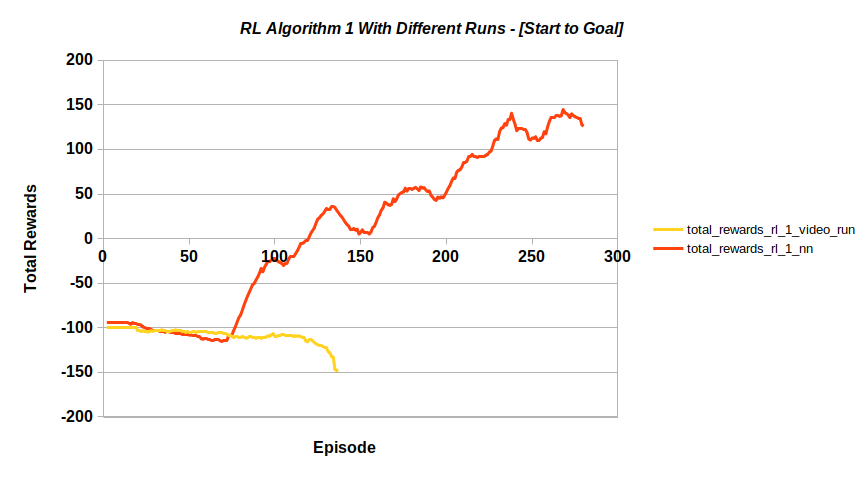

In [1]:
Image('/content/Results_RL_1_videp.png', width=650, height=375)

So, video recordings are shared from the last training which does not perform well with same algorithm and files. 

From the possible scenarios, change of tensorflow version between 2 runs, initialization of weights are may be the problem. 

I had to change tensorflow version >2 to run RL 2 model. To overcome this issue I re-install 1.15.0 then re-run again, however it wasn't good as initial run in chart 1 and chart 2. Then, I use initializer in tensorflow to use same initializer for each run, however I still couldn't  find a possible solution why this is happening. 

Same behaviour is observed in same algorithm with navigation 2. 

Therefore videos are taken one from near successful point in RL1 , and DQN with unsuccessful trials. 

There are 3 videos in sequence in video files:

1st : RL 1 (Policy Gradient DL) with successful training with goal reach threshold (chart 3 red curve)

2nd : RL 1 (Policy Gradient DL) with unsucessful training (chart 3 yellow curve)

3rd : RL 2 (DQN) with unsuccessful training (chart 2 blue curve) 